### Analysing Country yearly GDP as a feature

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "naive_approach_xgboost_optuna"
data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


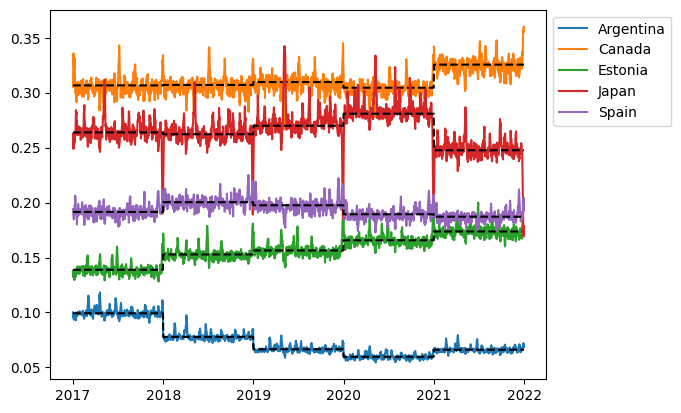

In [3]:
import requests

def get_gdp_per_capita(country,year):
    alpha3 = {'Argentina':'ARG','Canada':'CAN','Estonia':'EST','Japan':'JPN','Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

gdp = []
for country in df_train.country.unique():
    row = []
    for year in range(2017,2023):
        row.append(get_gdp_per_capita(country,year))
    gdp.append(row)

gdp = np.array(gdp)
gdp /= np.sum(gdp,axis=0)

rel_gdp_df = pd.DataFrame(gdp,index=df_train.country.unique(),columns=range(2017,2023))

df = df_train \
    .groupby(['date','country'])[['num_sold']] \
    .sum().reset_index() \
    .join(
        df_train.groupby('date')[['num_sold']].sum(), 
        on='date',
        rsuffix='_total'
    )
df['fractions'] = df['num_sold']/df['num_sold_total']
df['rel_gdp'] = df.apply(lambda s: rel_gdp_df.loc[s.country,s.date.year],axis=1)

for country in df['country'].unique():
    X = df[df['country']==country]
    plt.plot(X['date'],X['fractions'],label=country)
    plt.plot(X['date'],X['rel_gdp'],'k--')
    
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [8]:
rel_gdp_df

,2017,2018,2019,2020,2021,2022
Argentina,0.099274,0.077784,0.066531,0.059671,0.066117,0.085457
Canada,0.306587,0.306963,0.309657,0.304448,0.325473,0.343217
Estonia,0.138844,0.152769,0.156414,0.165711,0.173705,0.176912
Japan,0.263819,0.262142,0.269872,0.280831,0.247575,0.211147
Spain,0.191477,0.200342,0.197526,0.189340,0.187131,0.183266


In [9]:
rel_gdp_df.to_csv('data/rel_gdp.csv')
test = pd.read_csv('data/rel_gdp.csv', index_col=0)
test

,2017,2018,2019,2020,2021,2022
Argentina,0.099274,0.077784,0.066531,0.059671,0.066117,0.085457
Canada,0.306587,0.306963,0.309657,0.304448,0.325473,0.343217
Estonia,0.138844,0.152769,0.156414,0.165711,0.173705,0.176912
Japan,0.263819,0.262142,0.269872,0.280831,0.247575,0.211147
Spain,0.191477,0.200342,0.197526,0.189340,0.187131,0.183266
